# Mixed Monotonic

---

---

### Overview

This notebook trains a similar network to [simple_mlp](./simple_mlp.ipynb), but with a monotonic constraint on just the features `x1` and `x2`.  `x3` continues to enter as an embedding, and `x4` enters the model as a continuous feature without any monotonic constraints.

This notebook illustrates the use of Orthonormal Certificates to estimate epistemic uncertainty based on the training data provided to the model.

Notice:
- We're importing `MixedMonotonicNet()` from `tabularasa`.  This is a predefined network that takes a user-defined network as input, and combines that network's output with montonic features and a special monotonic network to generate predictions.
- We're importing `MixedMonotonicRegressor()` from `tabularasa`.  This isn't strictly necessary, and `MixedMonotonicNet()` could be trained with `skorch.NeuralNetRegressor()` (or even the standard PyTorch API).  In fact, `MixedMonotonicRegressor()` is defined to inherit the `skorch.NeuralNet()` class and is very similar to `NeuralNetRegressor()`, with the exception of special arguments needed to generate Orthonormal Certificates.
- `OrthonormalCertificatesNet()` and `OrthonormalCertificatesRegressor()` exist are similarly specialized.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from tabularasa.MixedMonotonic import MixedMonotonicRegressor, MixedMonotonicNet
from tabularasa.OrthonormalCertificates import OrthonormalCertificatesRegressor, OrthonormalCertificatesNet

---

### Load example data

If you haven't already, please generate the example dataset using the [example_data](example_data.ipynb) notebook.

In [2]:
df = pd.read_pickle('./data/simple_train.pkl')

---

### Define the user-specified network and model

Notice:
- Similar to [simple_mlp](simple_mlp.ipynb) we have a small embedding layer and then pass those embeddings as well as `x4` through a linear layer with ReLU activation.  Theoretically, this network could be much deeper and more complex, but for speed of training, we'll keep it simple.
- `x1` and `x2` are monotonically constrained, so are not sent through `EmbeddingNet()`.
- The `.forward()` method requires exactly one input that must be named `X_non_monotonic`.  This requires the suboptimal step of parsing the features by column index and converting types.  Note that the `TabulaRasaRegressor()`, show in [tabula_rasa](./tabula_rasa.ipynb), handles this for you.

In [3]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb1 = nn.Embedding(50, 16)
        self.fc1 = nn.Linear(1 + 16, 16)
    
    def forward(self, X_non_monotonic):
        X = torch.cat([X_non_monotonic[:, 1, None].float(), 
                       self.emb1(X_non_monotonic[:, 0, None].long()).squeeze()], 1)
        return F.relu(self.fc1(X))

When initializing `MixedMonotonicRegressor()`, we need to pass several specific arguments to the module `MixedMonotonicNet()`, this is done in skorch using the prefix `module__`:
- `non_monotonic_net`: passes in the simple embedding network defined above, which handles the non-monotonically constrained features we'd like to train on.
  - The library doesn't currently support models with no non-monotonic features.  An alternative would be to create a non-monotonic network whose `.forward()` pass directly sends its input as output, and then define a single feature of all 0s to be the only non-monotonic input.
- `dim_non_monotonic`: is the output dimension from `non_monotonic_net`.
- `dim_monotonic`: is the number of features we'd like to monotonically constrain on.  In this case `x1` and `x2`.
  - Note, by default, that features are constrained to have a monotonically _increasing_ relationship with the target variable.  For monotonically _decreasing_ relationships you'll need to multiply the feature by -1.
- `layers`: is a list with the number of nodes in each hidden layer of the monotonic neural network.
- `integration_steps`: is an optional tuning parameter for the montonic network.  See [Wehenkel and Louppe (2019)](https://arxiv.org/pdf/1908.05164.pdf) for more details.

In [4]:
model = MixedMonotonicRegressor(MixedMonotonicNet,
                                max_epochs=100,
                                lr=0.005,
                                optimizer=torch.optim.Adam,
                                iterator_train__shuffle=True,
                                module__non_monotonic_net=EmbeddingNet(),
                                module__dim_non_monotonic=16,
                                module__dim_monotonic=2,
                                module__layers=[128, 128, 32],
                                module__integration_steps=300)

The `.forward()` pass of `MixedMonotonicNet()` takes in exactly two arguments `X_monotonic` and `X_non_monotonic`.  We specify them as `dict` keys with numpy arrays as values.

In [5]:
model.fit({'X_monotonic': df[['x1', 'x2']].values,
           'X_non_monotonic': df[['x3', 'x4']].values},
          df[['y']].values)

  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        0.9056        0.4382  13.3817
      2        0.3472        0.4227  12.7113
      3        0.3297        0.3703  12.7761
      4        0.3046        0.3529  12.4777
      5        0.2856        0.3239  12.8205
      6        0.2694        0.3044  12.7401
      7        0.2420        0.2679  12.9352
      8        0.1981        0.2117  12.9445
      9        0.1454        0.1533  12.3733
     10        0.1068        0.1216  12.6098
     11        0.0997        0.1308  13.1193
     12        0.0780        0.0899  12.5158
     13        0.0727        0.1095  12.2664
     14        0.0727        0.1004  12.7092
     15        0.0666        0.0808  12.5589
     16        0.0627        0.0908  12.7204
     17        0.0596        0.0885  12.9945
     18        0.0590        0.0876  12.8043
     19        0.0594        0.0895  13.0524
     20        0.0582        0.0850  12.8011
     21   

<class 'tabularasa.MixedMonotonic.MixedMonotonicRegressor'>[initialized](
  module_=MixedMonotonicNet(
    (non_monotonic_net): EmbeddingNet(
      (emb1): Embedding(50, 16)
      (fc1): Linear(in_features=17, out_features=16, bias=True)
    )
    (monotonic_net): SlowDMonotonicNN(
      (outer_net): MonotonicNN(
        (integrand): IntegrandNN(
          (inner_net): Sequential(
            (0): Linear(in_features=17, out_features=128, bias=True)
            (1): ReLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): ReLU()
            (4): Linear(in_features=128, out_features=32, bias=True)
            (5): ReLU()
          )
          (net): Sequential(
            (0): Linear(in_features=17, out_features=128, bias=True)
            (1): ReLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): ReLU()
            (4): Linear(in_features=128, out_features=32, bias=True)
            (5): ReLU()
            (6)

We'll create a partial dependence plot to visualize how the monotonic network constrained our relationship between `x1` and `y`.

In [6]:
quantiles = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]

In [7]:
results = []
for q in np.quantile(df['x1'], quantiles):
    dfc = df.copy()
    dfc['x1'] = q
    dfc['x1'] = dfc['x1'].astype('float32')
    p = model.predict({'X_monotonic': dfc[['x1', 'x2']].values,
                       'X_non_monotonic': dfc[['x3', 'x4']].values})
    p = pd.DataFrame(pd.Series(p[:, 0]).describe(percentiles=quantiles)).T
    p['x1'] = q
    results.append(p)
results = pd.concat(results, axis=0)

We can see below that, unlike with the simple MLP network, we have a monotonically increasing relationship between `x1` and `y`.

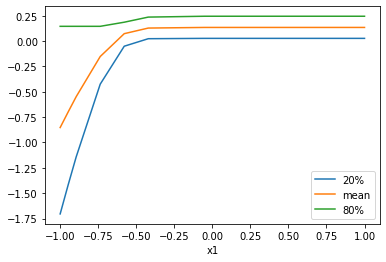

In [8]:
results.plot(x='x1', y=['20%', 'mean', '80%'])
plt.show()

---

### Epistemic uncertainty

Orthornormal certificates train a set of linear functions designed to map training examples to a value of 0, and other data points to a value greater than zero.  The input to the orthonormal certificates is typically the output of the last hidden layer of the trained network, which is treated as a deep featurization of the orignal input.

In some preliminary experiments, passing the initial, untransformed data as well provided better results.  Here, we'll concatenate the continuous features, with the output from the last hidden layer of our monotonic neural network as input to train the orthonormal certificates.

Note, `MixedMonotonicNet()` has an argument `last_hidden_layer` that can be passed to `MixedMonotonicRegressor().predict()` specifically for this purpose.

In [9]:
X_hidden = model.predict({'X_monotonic': df[['x1', 'x2']].values,
                          'X_non_monotonic': df[['x3', 'x4']].values},
                         last_hidden_layer=True)

Now we can generate orthonormal certificates.

Note, `OrthonormalCertificatesNet()` is very simple, so a large number of epochs can be specified without lengthy training time.  Specific arguments include:
- `dim_input`: Which is the size of the last layer in our `MixedMonotonicNet()` `layers` argument, plus any additional features we'd like to input (in this case the raw values for 3 continuous features `x1`, `x2`, and `x3`).
- `dim_certificates`: The number of linear functions to use.  If this number is too small, we won't be able to well represent a complex dataset.  Too large and our orthonormal certificates network will be unwieldy and more difficult to train.

In [10]:
ocr = OrthonormalCertificatesRegressor(OrthonormalCertificatesNet,
                                       max_epochs=150,
                                       lr=0.01,
                                       optimizer=torch.optim.Adam,
                                       iterator_train__shuffle=True,
                                       module__dim_input=32 + 3,
                                       module__dim_certificates=64)

In [11]:
ocr.fit(np.concatenate([df[['x1', 'x2', 'x4']].values, X_hidden], axis=1))

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        5.5880        2.4168  0.0430
      2        1.6026        0.8636  0.0444
      3        0.5410        0.3657  0.0539
      4        0.2743        0.1181  0.0431
      5        0.1206        0.0670  0.0433
      6        0.0596        0.0453  0.0441
      7        0.0371        0.0316  0.0492
      8        0.0276        0.0255  0.0418
      9        0.0230        0.0234  0.0455
     10        0.0208        0.0223  0.0494
     11        0.0195        0.0210  0.0435
     12        0.0187        0.0202  0.0469
     13        0.0181        0.0196  0.0442
     14        0.0176        0.0189  0.0448
     15        0.0170        0.0183  0.0452
     16        0.0165        0.0179  0.0459
     17        0.0161        0.0173  0.0437
     18        0.0157        0.0168  0.0489
     19        0.0154        0.0164  0.0459
     20        0.0150        0.0160  0.0524
     21        0.0146        0.0

    140        0.0092        0.0092  0.0452
    141        0.0092        0.0101  0.0430
    142        0.0094        0.0094  0.0395
    143        0.0094        0.0103  0.0397
    144        0.0096        0.0103  0.0434
    145        0.0094        0.0091  0.0425
    146        0.0091        0.0092  0.0472
    147        0.0091        0.0092  0.0423
    148        0.0091        0.0092  0.0416
    149        0.0091        0.0091  0.0430
    150        0.0091        0.0092  0.0418


<class 'tabularasa.OrthonormalCertificates.OrthonormalCertificatesRegressor'>[initialized](
  module_=OrthonormalCertificatesNet(
    (certificates): Linear(in_features=35, out_features=64, bias=True)
  ),
)

We'll create another partial dependence-like plot, except with the uncertainty estimates from our orthonormal certificates model.

Note, that we include `x1` values outside of the initially defined range to see whether our estimate of uncertainty increases in those areas (as we would expect).

In [12]:
uncertainties = []
for q in np.linspace(-1.5, 1.5, 101):
    dfc = df.copy()
    dfc['x1'] = q
    dfc['x1'] = dfc['x1'].astype('float32')
    p = ocr.predict(np.concatenate([dfc[['x1', 'x2', 'x4']],
                                    model.predict({'X_monotonic': dfc[['x1', 'x2']].values,
                                                   'X_non_monotonic': dfc[['x3', 'x4']].values},
                                                  last_hidden_layer=True)], axis=1))
    p = pd.DataFrame(pd.Series(p).describe(percentiles=quantiles)).T
    p['x1'] = q
    uncertainties.append(p)
uncertainties = pd.concat(uncertainties, axis=0)

Notice below that:
- Uncertainty is high when `x1` is below -1 and above 1.  This is what we'd expect given that none the training data has values outside of this range.
- Uncertainty is also moderately high when `x1` is between 0 and 0.5 where data was deliberately exclued.

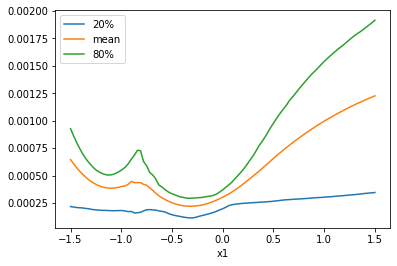

In [13]:
uncertainties.plot(x='x1', y=['20%', 'mean', '80%'])
plt.show()

The raw values output by our orthonormal certificates can have varying magnitude.  How high does an uncertainty value need to be before we need to be concerned about model reliability?

`OrthonormalCertificatesRegressor()` includes two additional methods to help with this.  Both use the validation data skorch automatically creates during training to approximate what in-sample, but data that's still different from the training set, looks like.
- `percentile_predict()`: returns the percentile (an integer from 0 to 100) that the input records uncertainty value maps to.
- `scaled_predict()`: returns a positive float, where uncertainty is divided by the maximum uncertainty seen in the validation dataset.  i.e. values > 1 are more uncertain than every record in the validation dataset.

In [14]:
uncertainties = []
for q in np.linspace(-1.5, 1.5, 101):
    dfc = df.copy()
    dfc['x1'] = q
    dfc['x1'] = dfc['x1'].astype('float32')
    p = ocr.scaled_predict(np.concatenate([dfc[['x1', 'x2', 'x4']],
                                           model.predict({'X_monotonic': dfc[['x1', 'x2']].values,
                                                          'X_non_monotonic': dfc[['x3', 'x4']].values},
                                                         last_hidden_layer=True)], axis=1))
    p = pd.DataFrame(pd.Series(p).describe(percentiles=quantiles)).T
    p['x1'] = q
    uncertainties.append(p)
uncertainties = pd.concat(uncertainties, axis=0)

Scaling the results of the plot above provides more context to our previous interpretations about uncertainty.

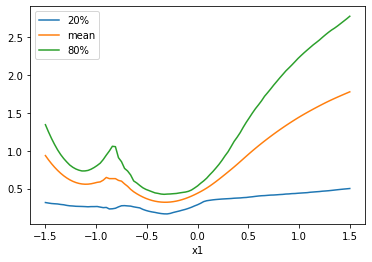

In [15]:
uncertainties.plot(x='x1', y=['20%', 'mean', '80%'])
plt.show()

To review estimates for aleatoric uncertainty, see the [simultaneous_quantiles](./simultaneous_quantiles.ipynb) example, or jump straight to the [tabula_rasa](./tabula_rasa.ipynb) example to see everything brought together.